In [7]:
using PyPlot

In [108]:
# discretization
t = Array(2020:1.:2100);

# CO2 concentration (ppm) at t[1]
c_00 = 415.;

# physical climate parameters
ECS = 3.; # Equilibrium Climate Sensitivity
ϵ = ECS/log(2.); # Transient Warming Parameter
δT_00 = 1.1; # Warming at t[1] since preindustrial

# baseline emissions scenarios
q = 2. .* ones(size(t)); # emissions scenario
c_0 = c_00 .+ cumsum(q); # cumulative CO2 concentrations (ppm)
δT_0 = δT_00 .+ ϵ.*log.(c_0/c_00); # warming due to baseline emissions scenario

# economic parameters
β = 2.2; # damage parameter (trillion dolars / C^2)
D_0 = β .* δT_0.^2; # baseline damages
γ = 0. #1. /30. # discount rate
C_ϕ = 400.; # trillion $
C_φ = 100.; # trillion $
C_χ = 150.; # trillion $
C_λ = 150.; # trillion $

In [109]:
c(ϕ::Array, φ::Array) = (c_0 .- cumsum(q .* φ)) .* (1. .- ϕ);
δT(ϕ::Array, φ::Array) = δT_00 .+ ϵ.*log.(c(ϕ,φ)./c_00);

f_low(α::Array) = (α ./ (1. .+α)).^2 # shape of individual cost functions

D(ϕ::Array, φ::Array, χ::Array, λ::Array) = (1. .- χ) .* β .* δT(ϕ, φ).^2 .* (1. .- λ).^2;
C(ϕ::Array, φ::Array, χ::Array, λ::Array) = C_λ.*f_low(λ) .+ C_ϕ.*f_low(ϕ) .+ C_φ.*f_low(φ) .+ C_χ.*f_low(χ);
T(ϕ::Array, φ::Array, χ::Array, λ::Array) = (
    sum((C(ϕ, φ, χ, λ) .+ D(ϕ, φ, χ, λ)) .* exp.(.-γ.*(t.-t[1]))) .+
    1000. * (sum(diff(ϕ).^2) .+ sum(diff(φ).^2) .+ sum(diff(χ).^2) .+ sum(diff(λ).^2)) .+
    1000. .* (ϕ[1].^2 .+ φ[1].^2 .+ χ[1].^2 .+ λ[1].^2)
);

## Gradient descent cost minimization

In [110]:
function ∇T(ϕ::Array, φ::Array, χ::Array, λ::Array)
    Δα = 1.e-4
    ∂T∂ϕ = zeros(size(ϕ))
    ∂T∂φ = zeros(size(φ))
    ∂T∂χ = zeros(size(χ))
    ∂T∂λ = zeros(size(λ))
    for i=1:length(ϕ)
        δα = zeros(size(ϕ))
        δα[i] = Δα
        ∂T∂ϕ[i] = (T(ϕ.+δα,φ,χ,λ) .- T(ϕ,φ,χ,λ))/Δα
        ∂T∂φ[i] = (T(ϕ,φ.+δα,χ,λ) .- T(ϕ,φ,χ,λ))/Δα
        ∂T∂χ[i] = (T(ϕ,φ,χ.+δα,λ) .- T(ϕ,φ,χ,λ))/Δα
        ∂T∂λ[i] = (T(ϕ,φ,χ,λ.+δα) .- T(ϕ,φ,χ,λ))/Δα
    end
    
    return (∂T∂ϕ, ∂T∂φ, ∂T∂χ, ∂T∂λ)
end

function convergence(∇T, tol = 1.e-6)
    norm = 0.
    for ∂T∂α = ∇T
        norm += sum(∂T∂α.^2)
    end
    return norm < tol
end

convergence (generic function with 2 methods)

#### initial guess

In [100]:
# Example control trajectories
# (picked because cost of controls + cost of controlled damage < uncontrolled damage)
nondim_linear(t::Array) = (t .- t[1])/(t[end] - t[1]);
ϕ = nondim_linear(t)/8.;
φ = nondim_linear(t)/8.;
λ = nondim_linear(t)/8.;
χ = nondim_linear(t)/8.;

In [101]:
count = 1
while convergence(∇T(ϕ, φ, χ, λ), 1.e-8) == false
    norm = 0.
    for ∂T∂α = ∇T(ϕ, φ, χ, λ)
        norm += sum(∂T∂α.^2)
    end
    print(norm, " ")
    Δs = 1.e-4
    ϕ .-= ∇T(ϕ, φ, χ, λ)[1].*Δs
    φ .-= ∇T(ϕ, φ, χ, λ)[2].*Δs
    χ .-= ∇T(ϕ, φ, χ, λ)[3].*Δs
    λ .-= ∇T(ϕ, φ, χ, λ)[4].*Δs
    count+=1
end

70405.79593251976 64173.347261867435 58644.1151967839 53656.13768024747 49135.84103667923 45032.535927533565 41305.40120837648 37919.343072450996 34843.23484283623 32049.015764859738 29511.16538872148 27206.36476214395 25113.25871955644 23212.27638785242 21485.486548662113 19916.474718665755 18490.234125335985 17193.06610582823 16012.48714999836 14937.141160925916 13956.716009996466 13061.864074005613 12244.126535753794 11495.861449573238 10810.175594904385 10180.86018285288 9602.330444273943 9069.569113964286 8578.073770825591 8123.807994225017 7703.156243908255 7312.882303916518 6950.091194608393 6612.1943791362155 6296.87800176883 6002.074126159462 5725.934612460017 5466.807552775275 5223.216037612702 4993.839050909207 4777.494334420503 4573.123048717063 4379.776031834438 4196.601588480933 4022.8345567503425 3857.7866031555095 3700.837598310593 3551.427953957919 3409.051828837299 3273.251103901906 3143.6100670642545 3019.7506765005387 2901.3284111931416 2788.028573695661 2679.563041

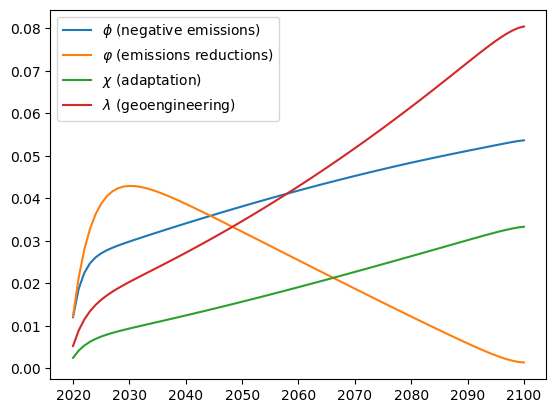

PyObject <matplotlib.legend.Legend object at 0x1498200b8>

In [103]:
plot(t, ϕ, label=L"$\phi$ (negative emissions)")
plot(t, φ, label=L"$\varphi$ (emissions reductions)")
plot(t, χ, label=L"$\chi$ (adaptation)")
plot(t, λ, label=L"$\lambda$ (geoengineering)")
legend()

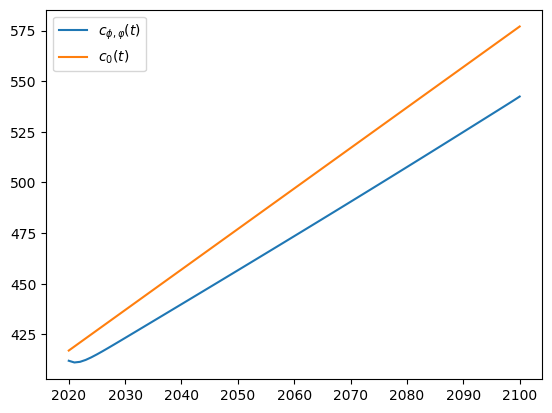

PyObject <matplotlib.legend.Legend object at 0x149bb0668>

In [104]:
plot(t,c(ϕ,φ), label=L"$c_{\phi,\varphi}(t)$")
plot(t,c_0, label=L"$c_{0}(t)$")
legend()

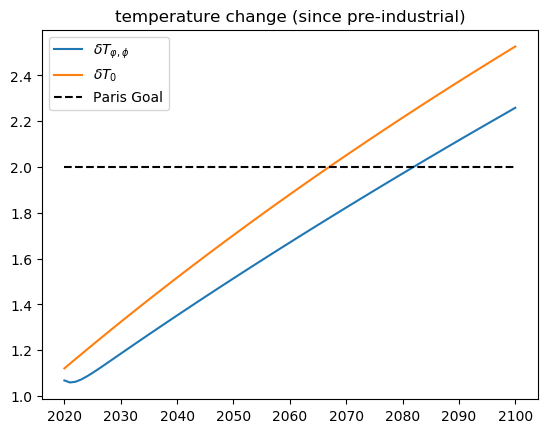

PyObject Text(0.5, 1, 'temperature change (since pre-industrial)')

In [105]:
plot(t,δT(ϕ, φ), label=L"\delta T_{\varphi,\phi}")
plot(t,δT_0, label=L"\delta T_{0}")
plot(t,2.0.*ones(size(t)),"k--", label="Paris Goal")
legend()
title("temperature change (since pre-industrial)")

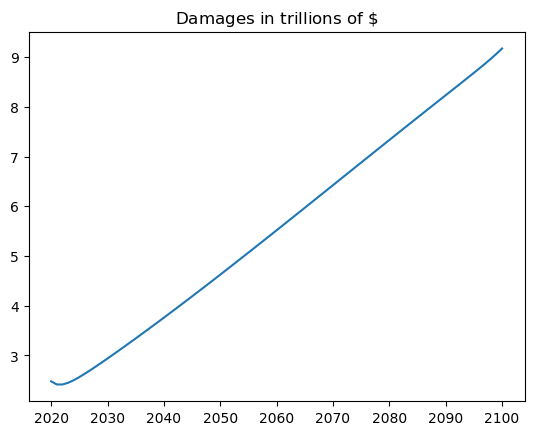

PyObject Text(0.5, 1, 'Damages in trillions of $\\$$')

In [106]:
plot(t, D(ϕ, φ, χ, λ))
title(L"Damages in trillions of $\$$")

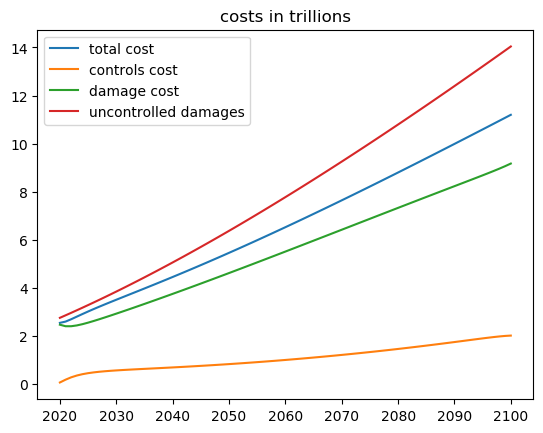

PyObject Text(0.5, 1, 'costs in trillions')

In [107]:
plot(t, C(ϕ, φ, χ, λ) + D(ϕ, φ, χ, λ), label="total cost")
plot(t, C(ϕ, φ, χ, λ), label="controls cost")
plot(t, D(ϕ, φ, χ, λ), label="damage cost")
plot(t, D_0, label="uncontrolled damages")
legend()
title("costs in trillions")